In [1]:
import pandas as pd  
import xlearn as xl  
import numpy as np 
import re 
import matplotlib.pyplot as plt 
import seaborn as sns


def data_sampling():
    # read data 
    movie_ids = pd.read_csv("./movie_info.csv")[["movie_id","movie_rating","movie_year","movie_detail"]]
    links = pd.read_csv("./links.csv")
    ratings = pd.read_csv("ratings.csv")

    # merge imdb movieid and movielens movieid
    links.columns = ["id","movie_id","tmdbId"]
    movie_ids = pd.merge(links,movie_ids,on="movie_id",how="inner")
    ratings.columns = ['user_id','id','rating','timestamp']
    ratings = pd.merge(ratings,movie_ids,on="id",how="inner")

    # sample users with more than 15 ratings
    user = ratings["user_id"].value_counts().reset_index()
    user = user[user.user_id>=15][["index"]]
    user.columns = ["user_id"]
    ratings_high = pd.merge(ratings,user,on="user_id",how="inner")
    ratings_high = ratings_high[['user_id','id','rating','timestamp','movie_rating','movie_year','movie_detail']]
    ratings_high.columns = ['user_id','movie_id','rating','timestamp','movie_rating','movie_year','movie_detail']


    # generate user index and movie index
    ratings_high_user = ratings_high.drop_duplicates(subset="user_id") \
        .sort_values(by="user_id").reset_index()['user_id'].reset_index()
    ratings_high_movie = ratings_high.drop_duplicates(subset="movie_id") \
        .sort_values(by="movie_id").reset_index()['movie_id'].reset_index()

    # merge dataframe 
    ratings_high = pd.merge(ratings_high,ratings_high_user,on="user_id",how="inner")
    ratings_high = pd.merge(ratings_high,ratings_high_movie,on="movie_id",how="inner")

    # change format to ffm format 
    ratings_high.columns = ['user_id','movie_id','rating','timestamp','movie_rating','movie_year','movie_detail','user_index','movie_index']
    ratings_high['movie_index'] = ratings_high['user_index'].max() + 1 + ratings_high['movie_index'] 
    ratings_high['user_index'] = ratings_high['user_index'].apply(lambda x: "0:"+str(x)+":1")
    ratings_high['movie_index'] = ratings_high['movie_index'].apply(lambda x: "1:"+str(x)+":1")

    # create 3 fold cv for hyper parameter tuning 
    ratings_high['rand'] = np.random.random(ratings_high.shape[0])
    ratings_high['rank'] = ratings_high.groupby("user_id")['rand'].rank(ascending=True,method="first")
    user_rating_num = ratings_high.groupby("user_id")["rank"].max().reset_index()
    ratings_high = pd.merge(ratings_high,user_rating_num,on="user_id",how="inner")
    ratings_high["group"] = ratings_high["rank_x"]/ratings_high["rank_y"]
    
    return ratings_high

def ffm_CV(ratings_high,columns,file_name):

    # Generate 3 fold cv

    ratings_high_train = ratings_high[columns][ratings_high.group>=0.33]
    ratings_high_test = ratings_high[columns][ratings_high.group<0.33]

    ratings_high_train.to_csv("./xlearn/"+file_name+"/ratings_high_train1.txt",
                                                                 sep=" ",
                                                                 index=False,
                                                                 header=None)
    with open("./xlearn/"+file_name+"/ratings_high_train1.txt", "r") as f:
        s = f.read()
    s = s.replace('"','')
    with open("./xlearn/"+file_name+"/ratings_high_train1.txt", 'w') as f:
        f.write(s)


    ratings_high_test.to_csv("./xlearn/"+file_name+"/ratings_high_test1.txt",
                                                                 sep=" ",
                                                                 index=False,
                                                                 header=None)
    with open("./xlearn/"+file_name+"/ratings_high_test1.txt", "r") as f:
        s = f.read()
    s = s.replace('"','')
    with open("./xlearn/"+file_name+"/ratings_high_test1.txt", 'w') as f:
        f.write(s)

    ratings_high_train = ratings_high[columns][(ratings_high.group<0.33)|(ratings_high.group>0.66)]
    ratings_high_test = ratings_high[columns][(ratings_high.group>=0.33)&(ratings_high.group<=0.66)]

    ratings_high_train.to_csv("./xlearn/"+file_name+"/ratings_high_train2.txt",
                                                                 sep=" ",
                                                                 index=False,
                                                                 header=None)
    with open("./xlearn/"+file_name+"/ratings_high_train2.txt", "r") as f:
        s = f.read()
    s = s.replace('"','')
    with open("./xlearn/"+file_name+"/ratings_high_train2.txt", 'w') as f:
        f.write(s)
    
    ratings_high_test.to_csv("./xlearn/"+file_name+"/ratings_high_test2.txt",
                                                                 sep=" ",
                                                                 index=False,
                                                                 header=None)
    with open("./xlearn/"+file_name+"/ratings_high_test2.txt", "r") as f:
        s = f.read()
    s = s.replace('"','')
    with open("./xlearn/"+file_name+"/ratings_high_test2.txt", 'w') as f:
        f.write(s)


    ratings_high_train = ratings_high[columns][ratings_high.group<=0.66]
    ratings_high_test = ratings_high[columns][ratings_high.group>0.66]

    ratings_high_train.to_csv("./xlearn/"+file_name+"/ratings_high_train3.txt",
                                                                 sep=" ",
                                                                 index=False,
                                                                 header=None)
    with open("./xlearn/"+file_name+"/ratings_high_train3.txt", "r") as f:
        s = f.read()
    s = s.replace('"','')
    with open("./xlearn/"+file_name+"/ratings_high_train3.txt", 'w') as f:
        f.write(s)
    ratings_high_test.to_csv("./xlearn/"+file_name+"/ratings_high_test3.txt",
                                                                 sep=" ",
                                                                 index=False,
                                                                 header=None)
    with open("./xlearn/"+file_name+"/ratings_high_test3.txt", "r") as f:
        s = f.read()
    s = s.replace('"','')
    with open("./xlearn/"+file_name+"/ratings_high_test3.txt", 'w') as f:
        f.write(s)



def ffm_cv_eval(k_lst, file_name):

    def NDCG(t):
        """
        compute NDCG for a user
        t: pandas dataframe 
        """
        rank = np.array(sorted(t['ranking'].values)[::-1])
        DCG = t.sort_values(by=["ranking"],ascending=False).rating.values
        IDCG = np.array(sorted(DCG))
        NDCG = (np.sum((2**(DCG)-1)/np.log2(rank+1))) / (np.sum((2**(IDCG)-1)/np.log2(rank+1)))
        return NDCG

    
    mse_lst = []
    NDCG_lst = []
    for k in k_lst:

        param = {'task':'reg', 'lr':0.2, 'lambda':0.02, 'metric':'mae', 'k':k}
        mse = []
        ndcg = []
        for i in ['1','2','3']:

            ffm_model = xl.create_ffm()               
            ffm_model.setTrain("./xlearn/"+file_name+"/ratings_high_train"+i+".txt")

            #ffm_model.setTXTModel("./xlearn/model.txt")
            ffm_model.fit(param, "./xlearn/"+file_name+"/ratings_high_model"+i+".out")
            # Prediction task
            ffm_model.setTest("./xlearn/"+file_name+"/ratings_high_test"+i+".txt")  # Set the path of test dataset
            # Start to predict
            # The output result will be stored in output.txt
            ffm_model.predict("./xlearn/"+file_name+"/ratings_high_model"+i+".out","./xlearn/"+file_name+"/ratings_high_output"+i+".txt")

            # update mse
            pred_ratings = pd.read_csv("./xlearn/"+file_name+"/ratings_high_output"+i+".txt",header=None)
            pred_ratings = list(pred_ratings[0])
            pred_ratings = [5 if i>5 else i for i in pred_ratings]
            pred_ratings = [0 if i<0 else i for i in pred_ratings]

            label_ratings = pd.read_csv("./xlearn/"+file_name+"/ratings_high_test"+i+".txt",header=None)
            label_ratings[0] = label_ratings[0].apply(lambda x: x.split(" ")[0:3])
            label_ratings["rating"] = label_ratings[0].apply(lambda x: x[0])
            label_ratings["rating"] = label_ratings["rating"].astype(float)
            label_ratings["user_id"] = label_ratings[0].apply(lambda x: x[1])
            label_ratings["movie_id"] = label_ratings[0].apply(lambda x: x[2])
            label_ratings = label_ratings[['rating','user_id','movie_id']]


            mse.append((np.sum((label_ratings["rating"] - pred_ratings)**2)/label_ratings.shape[0])**(1/2))

            # update ndcg
            label_ratings["pred_rating"] = pred_ratings
            label_ratings['ranking'] = label_ratings.groupby("user_id")["pred_rating"].rank(ascending=False,method="first")
            ndcg.append(label_ratings.groupby("user_id").apply(NDCG).mean())

        
        mse_lst.append(np.mean(mse))  
        NDCG_lst.append(np.mean(ndcg))
    
    return mse_lst,NDCG_lst



def Add_genre(ratings_high):

    movie_lda = pd.read_pickle("./genres_encode.pkl")
    movie_lda =  movie_lda[["movieId","genres_vec"]]
    movie_lda.columns = ['movie_id','genre_index']
    index_start = ratings_high.user_id.unique().shape[0] + ratings_high.movie_id.unique().shape[0]
    movie_lda['genre_index'] = movie_lda['genre_index'].apply(lambda x: 
                                 " ".join(["2:"+str(index+index_start)+":"+str(i) 
                                           for index,i in enumerate(x) if i != 0]))
    ratings_high = pd.merge(ratings_high,movie_lda,on="movie_id",how="inner")

    return ratings_high


def Add_tag(ratings_high):

    movie_lda = pd.read_pickle("./movie_lda_50.pkl")
    movie_lda =  movie_lda[["movieId","result"]]
    movie_lda.columns = ['movie_id','tag_index']
    index_start = ratings_high.user_id.unique().shape[0] + ratings_high.movie_id.unique().shape[0]
    movie_lda['tag_index'] = movie_lda['tag_index'].apply(lambda x: 
                                 (" ".join(["2:"+str(index+index_start)+":"+str(i) 
                                           for index,i in enumerate(x) if i >= 0.01])).strip('"'))
    ratings_high = pd.merge(ratings_high,movie_lda,on="movie_id",how="inner")

    return ratings_high

def Add_recent(ratings_high):

    def list_convert(l):
        if l != "":
            return " ".join(l)
        else:
            return ""

    ratings_high['time_rank'] = ratings_high.groupby("user_id")["timestamp"].rank(ascending=True,method="first")
    ratings_high_time = ratings_high[['rating','user_index','movie_index','time_rank']]

    ratings_high_time = pd.merge(ratings_high_time,ratings_high_time[['user_index','movie_index','time_rank']],on="user_index",how="inner")
    ratings_high_time["time_diff"] = ratings_high_time.time_rank_x - ratings_high_time.time_rank_y
    ratings_high_time = ratings_high_time[(ratings_high_time.time_diff>0)&(ratings_high_time.time_diff<4)]
    rating_recent = ratings_high_time.groupby(["user_index","movie_index_x"])["movie_index_y"].apply(lambda x: list(x)).reset_index()
    rating_recent.columns = ['user_index','movie_index','recent_index']
    ratings_high = pd.merge(ratings_high,rating_recent,on=["user_index","movie_index"],how="left")
    ratings_high.fillna("",inplace=True)
    ratings_high.recent_index = ratings_high.recent_index.apply(list_convert)

    return ratings_high


def Add_year(ratings_high):
    def convert_year(year):
        if year == 0:
            return 0
        elif year >= 2010:
            return 1
        elif year >= 2000:
            return 2
        elif year >= 1990:
            return 3
        else:
            return 4
    
    ratings_high["year_index"] = ratings_high.movie_year.apply(convert_year)
    index_start = ratings_high.user_id.unique().shape[0] + ratings_high.movie_id.unique().shape[0]
    ratings_high.year_index = ratings_high.year_index.apply(lambda x: "2:"+str(index_start+x)+":1")

    return ratings_high




def Add_country(ratings_high):

    def convert_country(country):
        if re.findall(r"'Country:(.*?)'",country) == []:
            return 0
        else:
            return re.findall(r"'Country:(.*?)'",country)[0]
        
    ratings_high["country"] = ratings_high['movie_detail'].apply(convert_country)

    movie_country = ratings_high.country.value_counts().reset_index()
    movie_country['country_index'] = [i for i in range(movie_country.shape[0])]
    movie_country.columns = ["country","num","country_index"]
    ratings_high = pd.merge(ratings_high,movie_country[["country","country_index"]],on="country")
    index_start = ratings_high.user_id.unique().shape[0] + ratings_high.movie_id.unique().shape[0]
    ratings_high.country_index = ratings_high.country_index.apply(lambda x: "2:"+str(index_start+x)+":1")
    
    return ratings_high

## data sampling 

In [3]:
ratings_high = data_sampling()

### Baseline

In [54]:
from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise import BaselineOnly
from surprise.model_selection import cross_validate

reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_high[['user_id', 'movie_id', 'rating']], reader)
algo = BaselineOnly()
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Estimating biases using als...
Evaluating RMSE, MAE of algorithm BaselineOnly on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8362  0.8429  0.8480  0.8478  0.8442  0.8438  0.0043  
MAE (testset)     0.6302  0.6356  0.6389  0.6392  0.6360  0.6360  0.0033  
Fit time          0.60    0.66    0.67    0.64    0.67    0.65    0.03    
Test time         0.32    0.33    0.20    0.32    0.20    0.28    0.06    


{'test_rmse': array([0.83623768, 0.84286113, 0.84796255, 0.8477725 , 0.84423761]),
 'test_mae': array([0.63015851, 0.63558764, 0.63891867, 0.63918296, 0.63596728]),
 'fit_time': (0.6041281223297119,
  0.6616456508636475,
  0.6728639602661133,
  0.6441709995269775,
  0.6718740463256836),
 'test_time': (0.3223459720611572,
  0.327991247177124,
  0.20232439041137695,
  0.32155799865722656,
  0.20430207252502441)}

In [12]:
ffm_CV(ratings_high,["rating","user_index","movie_index"],"mf")
k_lst = [1,3,5,10,15,20,25,30,35,40,45,50]
base_res = ffm_cv_eval(k_lst, "mf")

In [13]:
base_res

([0.8331023205204963,
  0.8246197664586808,
  0.8275621062538949,
  0.8381403632058738,
  0.8398902404775391,
  0.8414717199254835,
  0.8413921003666252,
  0.8390567629865157,
  0.8381214589530316,
  0.8366578761510516,
  0.8354834781068714,
  0.8348624917712808],
 [0.9051816801135778,
  0.9057685392006353,
  0.9048076756113096,
  0.9023757022278606,
  0.9024640356082378,
  0.9024023534048972,
  0.9028744293115226,
  0.9028478843615065,
  0.9033058364624839,
  0.9037948500479759,
  0.9044022678458545,
  0.9041258212333431])

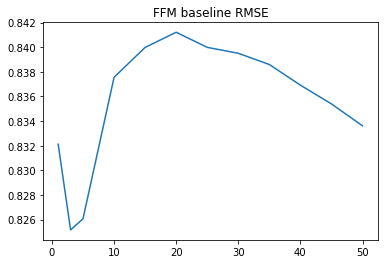

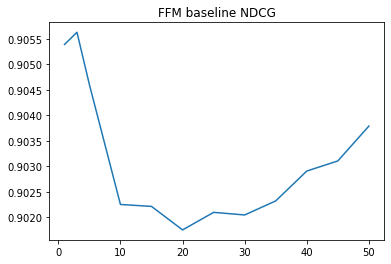

In [4]:
sns.lineplot(x=k_lst, y=base_res[0]);
plt.title("FFM baseline RMSE")
plt.show()
sns.lineplot(x=k_lst, y=base_res[1]);
plt.title("FFM baseline NDCG")
plt.show()

### Movie genres

In [5]:
ratings_high = Add_genre(ratings_high)
ffm_CV(ratings_high,["rating","user_index","movie_index","genre_index"],"mf_genre")
genre_res = ffm_cv_eval(k_lst, "mf_genre")

In [7]:
genre_res

([0.8237973943851175,
  0.8207693193146316,
  0.8196910278863799,
  0.8187210181552956,
  0.8186167031413946,
  0.8176218962832339,
  0.81784935771254,
  0.817726184884227,
  0.8169823263312964,
  0.817015754439642,
  0.8169422395552863,
  0.8167424942318743],
 [0.9074260711770906,
  0.9077752415005508,
  0.9078078141208924,
  0.9083509969695452,
  0.9084850901000574,
  0.9086889702140613,
  0.9084129098454539,
  0.9083221314006295,
  0.9086802904734723,
  0.9089212484555592,
  0.9087555709610898,
  0.9087619034024422])

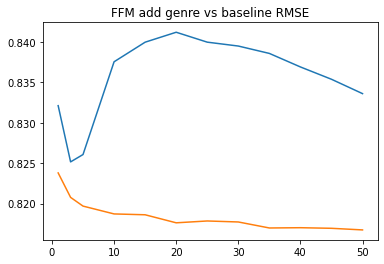

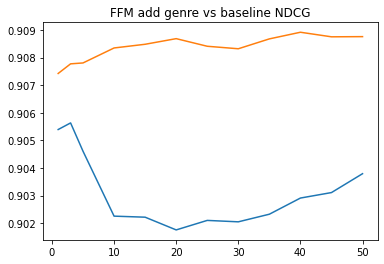

In [6]:
sns.lineplot(x=k_lst, y=base_res[0]);
sns.lineplot(x=k_lst, y=genre_res[0]);
plt.title("FFM add genre vs baseline RMSE")
plt.show()
sns.lineplot(x=k_lst, y=base_res[1]);
sns.lineplot(x=k_lst, y=genre_res[1]);
plt.title("FFM add genre vs baseline NDCG")
plt.show()

## Movie tags

In [9]:
ratings_high = Add_tag(ratings_high)
ffm_CV(ratings_high,["rating","user_index","movie_index","tag_index"],"mf_tag")
tag_res = ffm_cv_eval(k_lst, "mf_tag")

In [10]:
tag_res

([0.8326617283736774,
  0.8260805236620637,
  0.8237070839642225,
  0.8282232110748692,
  0.8306106604644952,
  0.8316655732650994,
  0.8314629217005782,
  0.8307218878278588,
  0.8284934208107968,
  0.8274797542788684,
  0.8265772511571369,
  0.8246159031745677],
 [0.9056471701976386,
  0.9063999625872569,
  0.9056961880092637,
  0.9045097080426857,
  0.9044070563493675,
  0.9035884950721322,
  0.9036278405057822,
  0.9047001207870803,
  0.9045566353941346,
  0.9047032787912986,
  0.9057755326053819,
  0.9059708251393769])

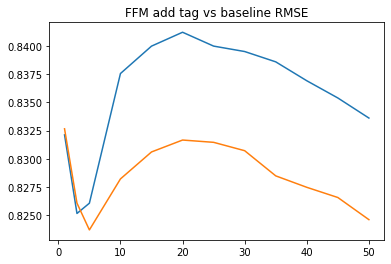

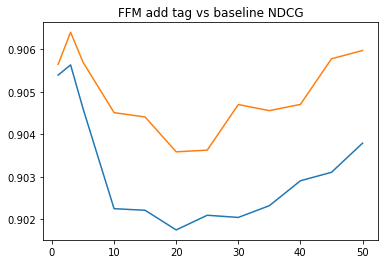

In [12]:
sns.lineplot(x=k_lst, y=base_res[0]);
sns.lineplot(x=k_lst, y=tag_res[0]);
plt.title("FFM add tag vs baseline RMSE")
plt.show()
sns.lineplot(x=k_lst, y=base_res[1]);
sns.lineplot(x=k_lst, y=tag_res[1]);
plt.title("FFM add tag vs baseline NDCG")
plt.show()

### Movie rating time

In [13]:
ratings_high = Add_recent(ratings_high)
ffm_CV(ratings_high,["rating","user_index","movie_index","recent_index"],"mf_recent")
recent_res = ffm_cv_eval(k_lst, "mf_recent")

In [15]:
recent_res

([0.8868309649642709,
  0.8863693442248956,
  0.8863218143935706,
  0.8861300974615052,
  0.8863675297874295,
  0.8863184363072959,
  0.8861548073969207,
  0.8862236642949987,
  0.8859937398032781,
  0.8860524016876464,
  0.8863216180160155,
  0.886327252813823],
 [0.8804740689263206,
  0.880507671362464,
  0.8806082231237781,
  0.8807727979763115,
  0.8806193401040447,
  0.8808049418981533,
  0.8807780627720967,
  0.8809318641776577,
  0.8808346478116215,
  0.8809855573304933,
  0.8809350133090619,
  0.8809120825750189])

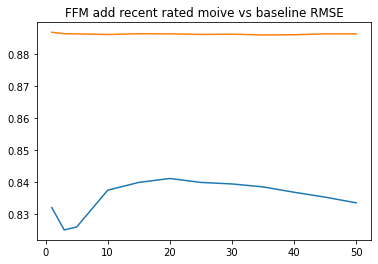

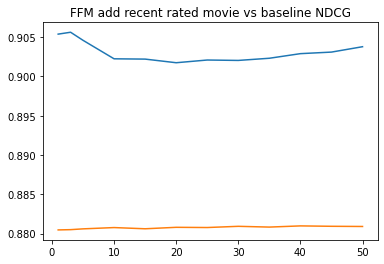

In [16]:
sns.lineplot(x=k_lst, y=base_res[0]);
sns.lineplot(x=k_lst, y=recent_res[0]);
plt.title("FFM add recent rated moive vs baseline RMSE")
plt.show()
sns.lineplot(x=k_lst, y=base_res[1]);
sns.lineplot(x=k_lst, y=recent_res[1]);
plt.title("FFM add recent rated movie vs baseline NDCG")
plt.show()

## Movie Year 

In [8]:
ratings_high = Add_year(ratings_high)
ffm_CV(ratings_high,["rating","user_index","movie_index","year_index"],"mf_year")
year_res = ffm_cv_eval(k_lst+[70,90,110], "mf_year")

In [9]:
year_res

([0.8310080965197129,
  0.8191021789616487,
  0.8162581798187739,
  0.8137567994843727,
  0.8137265821249051,
  0.8127537671834517,
  0.81261732600495,
  0.8120169241466589,
  0.8109699608635936,
  0.8108066078619561,
  0.8107538831818463,
  0.8104746597614447,
  0.8098317436508853,
  0.8095070917089607,
  0.8089438194096207],
 [0.9058109065046711,
  0.9081190675568998,
  0.9084333354292702,
  0.9096011406095507,
  0.9096094072121742,
  0.910083854308274,
  0.9099504213504002,
  0.9101637350009737,
  0.9103928132179191,
  0.9105145298213588,
  0.9106470859565884,
  0.9108212651008158,
  0.9111299362960974,
  0.9110846399889799,
  0.9113783700003717])

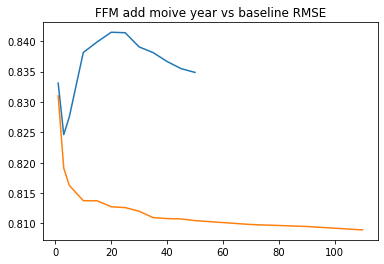

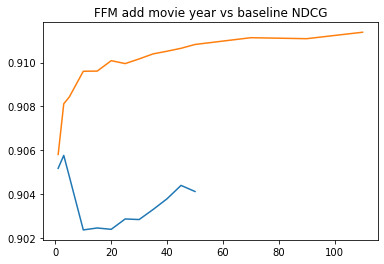

In [14]:
sns.lineplot(x=k_lst, y=base_res[0]);
sns.lineplot(x=k_lst+[70,90,110], y=year_res[0]);
plt.title("FFM add moive year vs baseline RMSE")
plt.show()
sns.lineplot(x=k_lst, y=base_res[1]);
sns.lineplot(x=k_lst+[70,90,110], y=year_res[1]);
plt.title("FFM add movie year vs baseline NDCG")
plt.show()

## Movie country

In [6]:
ratings_high = Add_country(ratings_high)
ffm_CV(ratings_high,["rating","user_index","movie_index","country_index"],"mf_country")
country_res = ffm_cv_eval(k_lst, "mf_country")

In [7]:
country_res

([0.8320543372115393,
  0.8208586835913279,
  0.8164005126654937,
  0.8144088324404989,
  0.8134135525511379,
  0.8121828459008155,
  0.8121024389730856,
  0.8114786732366586,
  0.8104438279304084,
  0.8104094308813874,
  0.8105118400282428,
  0.810055661891585],
 [0.9059333880693101,
  0.9079257501581232,
  0.9085182116313669,
  0.9095185858897493,
  0.9095812574595551,
  0.909843300545481,
  0.9097919090870682,
  0.910348609392234,
  0.9101067594177502,
  0.9105868293961165,
  0.9108301863763607,
  0.910720311327213])

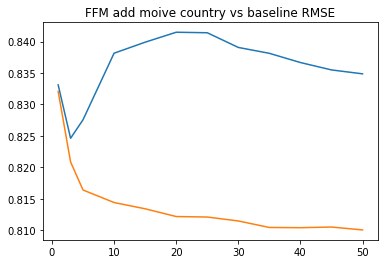

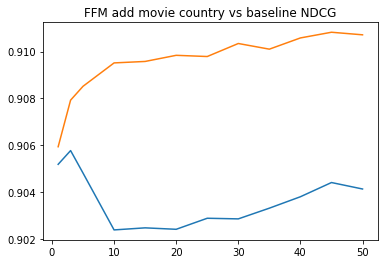

In [16]:
sns.lineplot(x=k_lst, y=base_res[0]);
sns.lineplot(x=k_lst, y=country_res[0]);
plt.title("FFM add moive country vs baseline RMSE")
plt.show()
sns.lineplot(x=k_lst, y=base_res[1]);
sns.lineplot(x=k_lst, y=country_res[1]);
plt.title("FFM add movie country vs baseline NDCG")
plt.show()

## Ensemble

In [5]:
ratings_high = data_sampling()
ratings_high = Add_country(ratings_high)
ratings_high = Add_year(ratings_high)
ratings_high = Add_genre(ratings_high)

ratings_high.country_index = ratings_high.country_index.apply(
        lambda x: "3:"+str(int(x.split(":")[1])+20)+":1")
ratings_high.year_index = ratings_high.year_index.apply(
        lambda x: "4:"+str(int(x.split(":")[1])+20+89)+":1")

ffm_CV(ratings_high,["rating","user_index","movie_index","genre_index","country_index","year_index"],"mf_ensemble")
k_lst = [1,3,5,10,15,20,25,30,35,40,45,50]
ensem_res = ffm_cv_eval(k_lst, "mf_ensemble")

In [7]:
ensem_res

([0.8332007417028664,
  0.8312245917836284,
  0.8309054024977169,
  0.8298309448614432,
  0.8300787505587266,
  0.8295397212145329,
  0.8295383453292472,
  0.8296256222175921,
  0.8294467005371439,
  0.8295066339261559,
  0.8298672322208046,
  0.8293679552597094],
 [0.9070807314581755,
  0.907510931973663,
  0.9077509247707961,
  0.9077863359928396,
  0.9078062888843541,
  0.9078502959292414,
  0.9079146380475188,
  0.9079116758670932,
  0.9079067231924395,
  0.9078837642865661,
  0.9078808719148728,
  0.9079412668280695])

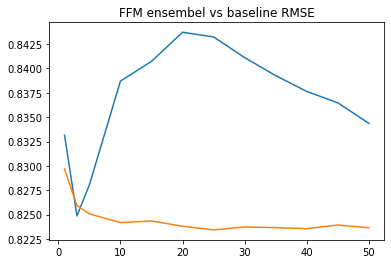

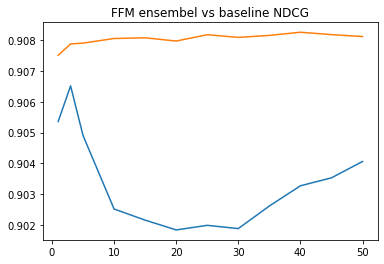

In [13]:
sns.lineplot(x=k_lst, y=base_res[0]);
sns.lineplot(x=k_lst, y=ensem_res[0]);
plt.title("FFM ensembel vs baseline RMSE")
plt.show()
sns.lineplot(x=k_lst, y=base_res[1]);
sns.lineplot(x=k_lst, y=ensem_res[1]);
plt.title("FFM ensembel vs baseline NDCG")
plt.show()